In [24]:
import pandas as pd
import os
import ast

# name = os.listdir('D://database//sentence_similiarty')

In [20]:
name

['dev_20200228.csv',
 'test.example_20200228.csv',
 'test.pred.example_20200228.csv',
 'train_20200228 (1).csv']

In [21]:
df = pd.read_csv(os.path.join('D://database//sentence_similiarty', name[-1]))

In [7]:
df.head()

,id,category,query1,query2,label
0,0,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血是什么原因？,1
1,1,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后为什么会咯血？,1
2,2,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血，应该怎么处理？,0
3,3,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血，需要就医吗？,0
4,4,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血，是否很严重？,0


In [8]:
df.category.unique()

array(['咳血', '支原体肺炎', '胸膜炎', '肺气肿', '肺炎', '感冒', '上呼吸道感染', '哮喘'],
      dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

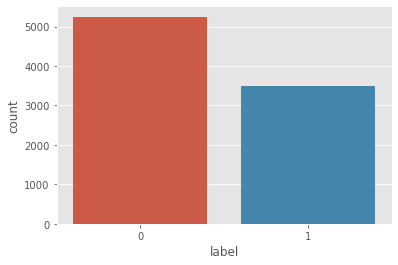

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.countplot(df.label)

In [18]:
import warnings
warnings.filterwarnings("ignore") 

<AxesSubplot:xlabel='category', ylabel='count'>

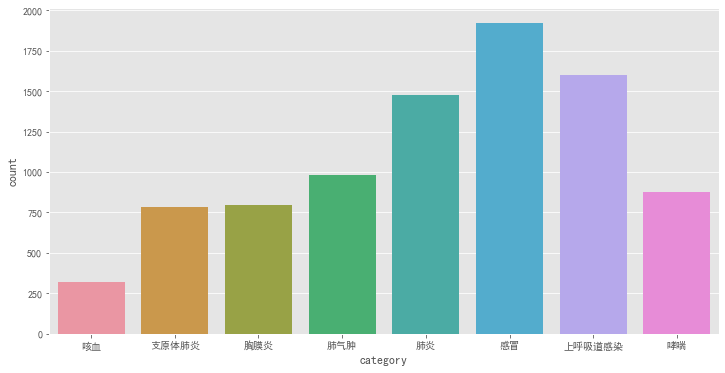

In [23]:
plt.figure(figsize = (12,6))
plt.rcParams['font.sans-serif'] = ['SimHei'] # Or any other Chinese characters
sns.countplot(df.category)

In [24]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [34]:
sentence1 = '剧烈运动后咯血,是怎么了?'
sentence2 = '剧烈运动后咯血是什么原因?'
input1 = tokenizer.encode_plus(sentence1,sentence2,return_tensors='pt')

In [36]:
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-chinese')
output = model(**input1)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
input1

{'input_ids': tensor([[ 101, 1196, 4164, 6817, 1220, 1400, 1492, 6117,  117, 3221, 2582,  720,
          749,  136,  102, 1196, 4164, 6817, 1220, 1400, 1492, 6117, 3221,  784,
          720, 1333, 1728,  136,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from utils import config

class SentenceModel(transformers.BertPreTrainedModel):
    def __init__(self,conf):
        super(SentenceModel,self).__init__(conf)
        self.bert = transformers.BertModel.from_pretrained(config.bert_path,config = conf
                                                           )
        self.drop = nn.Dropout(0.1)
        self.linear0 = nn.Linear(2*768,1)
        torch.nn.init.normal_(self.linear0.weight,std=0.02)
    def forward(self,ids,mask,token_type_ids):
        out = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        #here we get the dimension [num of hiddenstate , batch_size,sentence_len,768]
        out = torch.cat((out.hidden_states[-1],out.hidden_states[-2]),dim=-1)
        # so here we get  [batch size , sentence len , 2*768]
        out = self.drop(out)
        out = self.linear0(out)
        output = out.view(4, -1)
        return output

In [63]:
input1 = tokenizer.encode_plus(sentence1,sentence2,return_tensors='pt',max_length = 50,truncation=True,
                              padding=True)

In [68]:
class SentenceDataset:
    def __init__(self,df,tokenizer,max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, item):
        sentence1 = self.df.loc[item].query1
        sentence2 = self.df.loc[item].query2
        target = self.df.loc[item].label
        # Encode the tweet using the set tokenizer (converted to ids corresponding to word pieces)
        token =self.tokenizer.encode_plus(sentence1, sentence2,
                                          max_length = self.max_len,truncation=True,
                                          padding=True
                                          )
        token['target'] = target

        # padding the length
        input_ids = token['input_ids']
        mask = token['attention_mask']
        token_type_ids = token['token_type_ids']

        padding_length = self.max_len - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + ([0] * padding_length)
            mask = mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)


        return {
            'ids': torch.tensor(input_ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': target
        }

In [70]:
df_valid = pd.read_csv(config.valid_path)
valid_dataset = SentenceDataset(
    tokenizer=config.tokenizer,
    df=df_valid,
    max_len=config.max_len
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config.VALID_BATCH_SIZE,
    num_workers=0
)

In [112]:
class SentenceModel(transformers.BertPreTrainedModel):
    def __init__(self,conf,max_len):
        super(SentenceModel,self).__init__(conf)
        self.bert = transformers.BertModel.from_pretrained(config.bert_path,config = conf
                                                           )
        self.drop = nn.Dropout(0.1)
        self.linear0 = nn.Linear(2*768,1)
        self.linear1 = nn.Linear(max_len,1)
        torch.nn.init.normal_(self.linear0.weight,std=0.02)
    def forward(self,ids,mask,token_type_ids):
        out = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        #here we get the dimension [num of hiddenstate , batch_size,sentence_len,768]
        out = torch.cat((out.hidden_states[-1],out.hidden_states[-2]),dim=-1)
        # so here we get  [batch size , sentence len , 2*768]
        out = self.drop(out)
        out = self.linear0(out)
        output = out.view(4, -1)
        return self.linear1(output)

In [113]:
model_config = transformers.BertConfig.from_pretrained(config.BERT_PATH,output_hidden_states=True)
model = SentenceModel(conf=model_config,max_len = 30)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [146]:
import  torch.nn.functional  as F
loss = torch.nn.BCEWithLogitsLoss()

for d in valid_data_loader:
    ids = torch.tensor(d["ids"],dtype = torch.long)
    token_type_ids = torch.tensor(d["token_type_ids"],dtype = torch.long)
    mask =torch.tensor( d["mask"],dtype = torch.long)
    targets = torch.tensor(d["target"],dtype = torch.float)

    # Move ids, masks, and targets to gpu while setting as torch.long
#     ids = ids.to(device, dtype=torch.long)
#     token_type_ids = token_type_ids.to(device, dtype=torch.long)
#     mask = mask.to(device, dtype=torch.long)
#     targets = targets.to(device, dtype=torch.long)
#     print(targets.shape)
    model.zero_grad()
    target_predict = model(ids = ids,
                            mask = mask,
                            token_type_ids = token_type_ids)
#     target_predict = F.softmax(target_predict,dim=1)
#     print(target_predict.view(-1),targets)
    loss1 = loss(target_predict.view(-1),targets)
#     print(loss1)
    target_predict[[target_predict>0.5]] =1
    target_predict[[target_predict<0.5]] =0
    print(targets)
    real_sum = (target_predict.view(-1)==targets).sum()
    print(target_predict==targets)
    accuracy = real_sum/ids.shape[0]
    print(real_sum,accuracy)
    break
 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


tensor([1., 1., 0., 0.])
tensor([[False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True]])
tensor(2) tensor(0.5000)


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not int

In [42]:
# from stanfordcorenlp import StanfordCoreNLP

# nlp = StanfordCoreNLP(r'D:\database\standford\stanford-corenlp-4.4.0',lang='zh')

from stanfordcorenlp import StanfordCoreNLP

#默认是英文
nlp = StanfordCoreNLP(r'D:\database\standford\stanford-corenlp-4.2.0')
#如果要用其他语言，需要单独设置
# nlp_ch = StanfordCoreNLP(r'D:\database\standford\stanford-corenlp-4.2.0', lang='zh')

In [17]:
sentence = '清华大学位于北京。'
sentence2 = '剧烈运动后咯血,是怎么了?'
# print ('Tokenize:', nlp_ch.word_tokenize(sentence))
# print ('Part of Speech:', nlp_ch.pos_tag(sentence))
# print ('Named Entities:', nlp_ch.ner(sentence))
# print ('Constituency Parsing:', nlp_ch.parse(sentence))
print ('Dependency Parsing:', nlp_ch.dependency_parse(sentence))
print ('Dependency Parsing:', nlp_ch.dependency_parse(sentence2))


Dependency Parsing: [('ROOT', 0, 3), ('compound:nn', 2, 1), ('nsubj', 3, 2), ('dobj', 3, 4), ('punct', 3, 5)]
Dependency Parsing: [('ROOT', 0, 7), ('amod', 2, 1), ('advmod:loc', 4, 2), ('case', 2, 3), ('dep', 7, 4), ('punct', 7, 5), ('cop', 7, 6), ('aux:asp', 7, 8), ('punct', 7, 9)]


In [1]:
import pandas as pd
df = pd.read_csv('D:\\database\\sentence_similiarty\\BQ_corpus\\train.csv')

In [9]:
df_1 = df.loc[:10]
df_1

,sentence1,sentence2,label
0,用微信都6年，微信没有微粒贷功能,4。 号码来微粒贷,0
1,微信消费算吗,还有多少钱没还,0
2,交易密码忘记了找回密码绑定的手机卡也掉了,怎么最近安全老是要改密码呢好麻烦,0
3,你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？,什么时候可以到账,0
4,"“微粒贷开通""",你好，我的微粒贷怎么没有开通呢,0
5,为什么借款后一直没有给我回拨电话,怎么申请借款后没有打电话过来呢！,1
6,为什么我每次都提前还款了最后却不给我贷款了,30号我一次性还清可以不,0
7,请问一天是否都是限定只能转入或转出都是五万。,微众多少可以赎回短期理财,0
8,微粒咨询电话号码多少,你们的人工客服电话是多少,1
9,已经在银行换了新预留号码。,我现在换了电话号码，这个需要更换吗,1


In [56]:
#   coding=utf-8
import warnings
import tqdm
warnings.filterwarnings("ignore") 
from stanfordcorenlp import StanfordCoreNLP

# _*_coding:utf-8_*_

# Other human languages support, e.g. Chinese

sentence = '为什么借款后一直没有给我回拨电话。'

with StanfordCoreNLP(r'D:\database\standford\stanford-corenlp-4.2.0', lang='zh') as nlp:
#     print(nlp.word_tokenize(sentence))
#     print(nlp.pos_tag(sentence))
#     print(nlp.ner(sentence))
#     print(nlp.parse(sentence))
#     print(nlp.dependency_parse(sentence))
#     df['dependency1'] = df.sentence1.apply(lambda x:nlp.dependency_parse(x))
#     df['dependency2'] = df.sentence2.apply(lambda x:nlp.dependency_parse(x))
#     df['word1'] = df.sentence1.apply(lambda x:nlp.word_tokenize(x))
#     df['word2'] = df.sentence2.apply(lambda x:nlp.word_tokenize(x))
    word1 = []
    word2 = []
    sentence1 = []
    sentence2 = []
    for i in tqdm.tqdm(range(len(df))):
        one = df.loc[i].sentence1
        two = df.loc[i].sentence2
        try:
            word1.append(nlp.word_tokenize(one))
        except:
            word1.append('Nan')
            
        try:
            sentence1.append(nlp.dependency_parse(one))
        except:
            sentence1.append('Nan')
            
        try:
            word2.append(nlp.word_tokenize(two))
        except:
            word2.append('Nan')
            
        try:
            sentence2.append(nlp.dependency_parse(two))
        except:
            sentence2.append('Nan')
            
#             sentence1.append(nlp.dependency_parse(one))
#             word2.append(nlp.word_tokenize(two))
#             sentence2.append(nlp.dependency_parse(two))
#         except:
#             print('error occur')
#             word1.append('Nan')
#             sentence1.append('Nan')
#             word2.append('Nan')
#             sentence2.append('Nan')
    final = {'sentence1':word1,'sentence2':wrod2,'depdency1':sentence1,'depdency2':sentence2}
    





100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [39:31<00:00, 42.17it/s]


In [65]:
df1 = pd.DataFrame([word1,word2,sentence1,sentence2]).T

In [67]:
df1.columns = ['sentence1','sentence2','depdency1','depdency2']

In [69]:
df1['label'] = df['label']

In [71]:
df1.to_csv('train_transfer.csv',index =False )

In [4]:
df3 = pd.read_csv('train_transfer.csv')

In [30]:
name = []
for i in range(len(df3)):
    sentence = df3.iloc[i,2]
    if sentence != 'Nan':
        x = ast.literal_eval(sentence)
        for ii in x:
            if ii[0] not in name:
                name.append(ii[0])
#         print(ii[0])
#     print(sentence)
#     break

In [46]:
new_name = []
new_name.append(name[0])
for i in name[1:]:
    new_name.append(i)
    new_name.append(i+'_next')
    
new_data = pd.DataFrame(columns = new_name)


In [50]:
new_data1 = new_data.copy()
new_data2 = new_data.copy()

,ROOT,case,case_next,nmod:prep,nmod:prep_next,advmod,advmod_next,dep,dep_next,mark:clf,...,nsubjpass,nsubjpass_next,auxpass,auxpass_next,etc,etc_next,advmod:dvp,advmod:dvp_next,amod:ordmod,amod:ordmod_next


In [93]:
for i in range(len(df3)):
    new_data1.loc[i] = 0
    sentence1 = ast.literal_eval( df3.iloc[i,0])
    sentence2 = ast.literal_eval(df3.iloc[i,1])
    depdency1 = ast.literal_eval(df3.iloc[i,2])
    depdency2 = ast.literal_eval(df3.iloc[i,3])
    new_data1.loc[i,'ROOT'] = sentence1[depdency1[0][2]]
#     print(sentence1)
    for ii in depdency1[1:]:
        
       
        break
        new_data1.loc[i,ii[0]] = sentence1[ii[1]]
        new_data1.loc[i,ii[0]+'_next'] = sentence1[ii[2]]
    

2
1
2
1
2
1
2
1
3
1
8
1
7
1
7
2


IndexError: list index out of range

In [95]:
for i in range(len(df3)):
    
    depdency1 = ast.literal_eval(df3.iloc[i,2])
    print(depdency1)

[('ROOT', 0, 8), ('case', 2, 1), ('nmod:prep', 8, 2), ('advmod', 4, 3), ('dep', 2, 4), ('mark:clf', 4, 5), ('punct', 8, 6), ('dep', 8, 7), ('nsubj', 10, 9), ('ccomp', 8, 10), ('dobj', 10, 11)]
[('ROOT', 0, 3), ('compound:nn', 2, 1), ('nsubj', 3, 2), ('dep', 3, 4)]
[('ROOT', 0, 3), ('compound:nn', 2, 1), ('nsubj', 3, 2), ('aux:asp', 3, 4), ('dep', 12, 5), ('nsubj', 7, 6), ('acl', 10, 7), ('mark', 7, 8), ('compound:nn', 10, 9), ('dobj', 5, 10), ('advmod', 12, 11), ('ccomp', 3, 12), ('aux:asp', 12, 13)]
[('ROOT', 0, 2), ('nsubj', 2, 1), ('nsubj', 6, 3), ('compound:nn', 5, 4), ('nmod:tmod', 6, 5), ('nsubj', 17, 6), ('mark', 6, 7), ('neg', 9, 8), ('dep', 17, 9), ('dobj', 9, 10), ('case', 12, 11), ('nmod:prep', 17, 12), ('advmod:loc', 17, 13), ('case', 13, 14), ('advmod', 17, 15), ('aux:modal', 17, 16), ('ccomp', 2, 17), ('discourse', 17, 18), ('punct', 2, 19)]
[('ROOT', 0, 3), ('punct', 3, 1), ('advmod', 3, 2), ('punct', 3, 4)]
[('ROOT', 0, 8), ('advmod', 8, 1), ('advcl:loc', 8, 2), ('case'

[('ROOT', 0, 1), ('dep', 1, 2), ('mark:clf', 2, 3), ('xcomp', 6, 4), ('advmod', 6, 5), ('dep', 2, 6), ('punct', 6, 7), ('advmod', 9, 8), ('conj', 6, 9), ('dobj', 9, 10), ('punct', 6, 11)]
[('ROOT', 0, 9), ('nummod', 4, 1), ('mark:clf', 1, 2), ('cc', 4, 3), ('nsubj', 9, 4), ('punct', 9, 5), ('advmod', 9, 6), ('advmod', 9, 7), ('neg', 9, 8)]
[('ROOT', 0, 3), ('nsubj', 3, 1), ('advmod', 3, 2), ('det', 5, 4), ('dobj', 3, 5)]
[('ROOT', 0, 3), ('advmod', 3, 1), ('aux:modal', 3, 2), ('dobj', 3, 4), ('punct', 3, 5)]
[('ROOT', 0, 6), ('advmod:loc', 6, 1), ('case', 1, 2), ('aux:modal', 6, 3), ('advmod', 6, 4), ('advmod', 6, 5), ('dep', 6, 7)]
[('ROOT', 0, 3), ('advmod', 3, 1), ('aux:modal', 3, 2), ('dobj', 3, 4)]
[('ROOT', 0, 7), ('advmod', 7, 1), ('nmod:assmod', 4, 2), ('case', 2, 3), ('nsubj', 7, 4), ('advmod', 7, 5), ('neg', 7, 6)]
[('ROOT', 0, 3), ('advmod', 3, 1), ('nsubj', 3, 2), ('dep', 3, 4), ('dep', 3, 5), ('dobj', 3, 6)]
[('ROOT', 0, 3), ('advmod', 3, 1), ('advmod', 3, 2)]
[('ROOT', 0,

ValueError: malformed node or string: <_ast.Name object at 0x000001B2E4B22250>

In [38]:
## 词性总共有45个
len(name)

45

In [36]:
name1 = []
for i in range(len(df3)):
    sentence = df3.iloc[i,3]
    if sentence != 'Nan':
        x = (ast.literal_eval)(sentence)
        for ii in x:
            if ii[0] not in name1:
                name1.append(ii[0])

In [37]:
len(name1)

45

In [64]:
a = sentence1 = ast.literal_eval( df3.iloc[0,1])
sentence1 = ast.literal_eval( df3.iloc[2,2])

In [74]:
a[sentence1[0][2]]

'来'

In [73]:
a[4]

'微粒'

In [70]:
df3.head()

,sentence1,sentence2,depdency1,depdency2,label
0,"['用', '微信', '都', '6', '年', '，', '微信', '没有', '微...","['4', '。', '号码', '来', '微粒', '贷']","[('ROOT', 0, 8), ('case', 2, 1), ('nmod:prep',...","[('ROOT', 0, 1), ('punct', 1, 2), ('ROOT', 0, ...",0
1,"['微信', '消费', '算', '吗']","['还', '有', '多少', '钱', '没', '还']","[('ROOT', 0, 3), ('compound:nn', 2, 1), ('nsub...","[('ROOT', 0, 2), ('advmod', 2, 1), ('dep', 4, ...",0
2,"['交易', '密码', '忘记', '了', '找回', '密码', '绑定', '的',...","['怎么', '最近', '安全', '老是', '要', '改', '密码', '呢', ...","[('ROOT', 0, 3), ('compound:nn', 2, 1), ('nsub...","[('ROOT', 0, 10), ('advmod', 6, 1), ('nmod:tmo...",0
3,"['你', '好', '我', '昨天', '晚上', '申请', '的', '没有', '...","['什么', '时候', '可以', '到', '账']","[('ROOT', 0, 2), ('nsubj', 2, 1), ('nsubj', 6,...","[('ROOT', 0, 4), ('det', 2, 1), ('dep', 4, 2),...",0
4,"['“', '微粒贷', '开通', '""']","['你', '好', '，', '我', '的', '微粒贷', '怎么', '没有', '...","[('ROOT', 0, 3), ('punct', 3, 1), ('advmod', 3...","[('ROOT', 0, 2), ('nsubj', 2, 1), ('punct', 2,...",0
